## Using Police Data to Address Bias and Fairness in The Development of Data Science and Artificial Intelligence Systems

According to the Metropolitan Police, each rows in the dataset represents the use of force by an officer on one subject. This row set is not a count of incident. Where more than one officer has used force on the same subject, this will be shown on separate rows of data. As such this will result in duplicate metadata. Further consideration needs to be taken when analysing this data to ensure correct conclusions are drawn. For example if 2 officers use force on an individual who happens to be male aged 18-34 this will be shown on 2 rows of data. Hence, if grouping the data, you would have a count of 2x males and 2x 18-34 which would be incorrect.

The structure of the model is described in two phases. The first step is to successfully develop an AI model that aids in predictive policing. The model should be able to identify the suspect and the type of crime that is likely to be committed based on the data points on which it was trained. This will then prepare the police and assist them in deciding on a plan for using force.
The second step is to investigate for bias in the model and use the various metrics provided by IBM AIF360 toolkit to minimise any bias.

### Importing Various Libraries
**Panda** is used for data wrangling and preprocessing.
**Numpy** provides a range of array functions on a large collection of data.
**Matplotlib** is used for visualization.

Classifiers are used to test the performance and accuracy of the model using the machine algorithms below
- Random forest
- Logistic Regression
- Decision Tree

IBM fairness metrics tool box is used to check for bias in the model. The explainer is used to describe the outcome of the metrics in use. A comprehensive explanation on how to use the different metrics to mitigate bias such as reweighing and prejudice remover are available in the github link https://github.com/Trusted-AI/AIF360/tree/master/examples

In [246]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Fairness metrics
from aif360.datasets import BinaryLabelDataset 
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric 

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

### About the Dataset
The dataset in use was retrieved from the Metropolitan police (use of force) which can be accessed online. To download the dataset, kindly follow the link https://data.london.gov.uk/dataset/use-of-force

The dataset consist of 147,895 rows and 271 columns. Some of this rows consist of NaN (not a number) values. I showed the process of dealing with NaN values later in the code. You will also observe that 99% of the data consist of strings which are categorical in nature. I have used the categorical encoding libraries in python to convert the categorical values into numbers.

In [247]:
dataset=pd.read_csv("MPSUseofForceFY20-21.csv" , encoding='cp1252')
dataset

Columns (60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,138,178,218) have mixed types.Specify dtype option on import or set low_memory=False.


,IncidentDate,IncidentTime,Incident Location: Street/Highway,Incident Location: Public Transport,Incident Location: Retail Premises,"Incident Location: Open ground (e.g. park, car park, field)",Incident Location: Licensed Premises,Incident Location: Sports or Event Stadia,Incident Location: Hospital/A&E (non-mental-health setting),Incident Location: Mental Health Setting,...,SubjectInjured,SubjectNatureOfInjury,SubjectMedOffered,SubjectMedProvided,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other
0,01/04/2020,00:12:00,Yes,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,No
1,01/04/2020,01:30:00,Yes,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,Yes
2,01/04/2020,03:30:00,No,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,No
3,01/04/2020,04:25:00,No,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,No,No,No,No,Yes
4,01/04/2020,04:12:00,No,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147890,31/01/2021,18:00:00,No,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,No
147891,31/01/2021,15:20:00,Yes,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,No
147892,31/01/2021,22:00:00,No,No,No,No,No,No,No,No,...,Unknown,NaN,NaN,NaN,No,No,No,Yes,No,No
147893,31/01/2021,19:48:00,Yes,No,No,No,No,No,No,No,...,No,NaN,NaN,NaN,No,Yes,No,No,No,No


### Dealing with NaNs
I used python to count columns where each count represent the number of missing values alongside their percentage. After sorting each column, I realized **209** columns had **90-100** percent of missing values.
I ensured I dropped all the columns with **87%** of missing NaN values.  

In [248]:
train_test = pd.concat([dataset.drop('Impact Factor: Possesion of a weapon', axis = 1)], keys = ['dataset'], axis = 0)
missing_values = pd.concat([train_test.isna().sum(),
                            (train_test.isna().sum() / train_test.shape[0]) * 100], axis = 1, 
                           keys = ['Values missing', 'Percent of missing'])
missing_values.loc[missing_values['Percent of missing'] > 0].sort_values(ascending = False, by = 'Percent of missing').style.background_gradient('Blues')

,Values missing,Percent of missing
Effective 19,147895,100.000000
Tactic 18,147895,100.000000
Tactic 20,147895,100.000000
Tactic 16,147895,100.000000
Effective 16,147895,100.000000
Tactic 17,147895,100.000000
Effective 17,147895,100.000000
Tactic Effective 20,147895,100.000000
Effective 18,147895,100.000000
CED4 Drive Stun Repeat Application,147895,100.000000


### Dropping Columns
I am going to drop the columns with the highest percentage of missing values below.  

In [249]:
dataset=dataset.drop(['StaffInjuryIntentional','ThreatenedWithWeapon','AssaultedWithWeapon',
                      'Tactic 4','Effective 4','Tactic 5','Effective 5','Tactic 6','Tactic 7','Effective 6','Effective 7',
                      'Tactic 20','Tactic 8','Effective 8','Tactic 9','Effective 9','Tactic 10','Effective 10','Tactic 11',
                      'Effective 11', 'Tactic 12','Effective 12','Tactic 13', 'Effective 13','Tactic 14','Effective 14','Tactic 15',
                      'SubjectNatureOfInjury','SubjectMedProvided','CarryingCED','Tactic 2','Effective 2',
                      'Tactic 3', 'Effective 3','StaffInjuryLevel','StaffMedProvided','SubjectMedOffered','SubjectMedProvided',
                      'Effective 15','Tactic 16','Effective 16','Tactic 17','Effective 17','Tactic 18','Effective 18','Tactic 19','Effective 19','Tactic Effective 20','CED Used',
                       'CED Device Serial No','CED Drawn','CED Aimed','CED Arced','CED Red-Dotted','CED Drive Stun','CED Drive Stun Repeat Application',
                       'CED Angle Drive Stun','CED Fired','CED Fired Cartridge Number','CED Fired 5 Secs Cycle Interrupted','CED Fired Repeat Cycle Same Cartridge',
                       'CED Fired Total Number Of Cycles','CED Fired Cycle Extended Beyond 5 Secs','CED Fired Miss With One Probe','CED Fired Miss With Both Probes',
                       'CED Front 1','CED Front 2','CED Front 3','CED Front 4','CED Front 5','CED Front 6','CED Front 7','CED Front 8','CED Front 9','CED Front 10',
                       'CED Front 11','CED Front 12','CED Front 13','CED Front 14','CED Front 15','CED Back A','CED Back B','CED Back C','CED Back D','CED Back E',
                       'CED Back F','CED Back G','CED Back H','CED Back J','CED Back K','CED2 Drawn','CED2 Aimed','CED2 ArCED2','CED2 Red-Dotted','CED2 Drive Stun',
                       'CED2 Drive Stun Repeat Application','CED2 Angle Drive Stun','CED2 Fired','CED2 Fired Cartridge Number','CED2 Fired 5 Secs Cycle Interrupted',
                        'CED2 Fired Repeat Cycle Same Cartridge','CED2 Fired Total Number Of Cycles','CED2 Fired Cycle Extended Beyond 5 Secs',
                        'CED2 Fired Miss With One Probe', 'CED2 Fired Miss With Both Probes','CED2 Front 1','CED2 Front 2','CED2 Front 3',
                        'CED2 Front 4','CED2 Front 5','CED2 Front 6','CED2 Front 7','CED2 Front 8','CED2 Front 9','CED2 Front 10','CED2 Front 11',
                       'CED2 Front 12','CED2 Front 13','CED2 Front 14','CED2 Front 15','CED2 Back A','CED2 Back B','CED2 Back C','CED2 Back D','CED2 Back E',
                        'CED2 Back F','CED2 Back G','CED2 Back H','CED2 Back J','CED2 Back K','CED3 Drawn','CED3 Aimed','CED3 ArCED3','CED3 Red-Dotted',
                        'CED3 Drive Stun','CED3 Drive Stun Repeat Application','CED3 Angle Drive Stun','CED3 Fired','CED3 Fired Cartridge Number',
                        'CED3 Fired 5 Secs Cycle Interrupted','CED3 Fired Repeat Cycle Same Cartridge','CED3 Fired Total Number Of Cycles','CED3 Fired Cycle Extended Beyond 5 Secs',
                        'CED3 Fired Miss With One Probe','CED3 Fired Miss With Both Probes','CED3 Front 1','CED3 Front 2','CED3 Front 3','CED3 Front 4','CED3 Front 5',
                        'CED3 Front 6','CED3 Front 7','CED3 Front 8','CED3 Front 9','CED3 Front 10','CED3 Front 11','CED3 Front 12','CED3 Front 13',
                        'CED3 Front 14','CED3 Front 15','CED3 Back A','CED3 Back B','CED3 Back C','CED3 Back D','CED3 Back E','CED3 Back F','CED3 Back G',
                        'CED3 Back H','CED3 Back J','CED3 Back K','CED4 Drawn','CED4 Aimed','CED4 ArCED4','CED4 Red-Dotted','CED4 Drive Stun',
                        'CED4 Drive Stun Repeat Application','CED4 Angle Drive Stun','CED4 Fired','CED4 Fired Cartridge Number','CED4 Fired 5 Secs Cycle Interrupted',
                        'CED4 Fired Repeat Cycle Same Cartridge','CED4 Fired Total Number Of Cycles','CED4 Fired Cycle Extended Beyond 5 Secs',
                        'CED4 Fired Miss With One Probe','CED4 Fired Miss With Both Probes','CED4 Front 1','CED4 Front 2','CED4 Front 3','CED4 Front 4','CED4 Front 5',
                        'CED4 Front 6','CED4 Front 7','CED4 Front 8','CED4 Front 9','CED4 Front 10','CED4 Front 11','CED4 Front 12','CED4 Front 13','CED4 Front 14','CED4 Front 15',
                        'CED4 Back A','CED4 Back B','CED4 Back C','CED4 Back D','CED4 Back E','CED4 Back F','CED4 Back G','CED4 Back H','CED4 Back J','CED4 Back K'], axis=1)
dataset

,IncidentDate,IncidentTime,Incident Location: Street/Highway,Incident Location: Public Transport,Incident Location: Retail Premises,"Incident Location: Open ground (e.g. park, car park, field)",Incident Location: Licensed Premises,Incident Location: Sports or Event Stadia,Incident Location: Hospital/A&E (non-mental-health setting),Incident Location: Mental Health Setting,...,PhysicalDisability,MentalDisability,StaffInjured,SubjectInjured,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other
0,01/04/2020,00:12:00,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,No
1,01/04/2020,01:30:00,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,Yes
2,01/04/2020,03:30:00,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,No
3,01/04/2020,04:25:00,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes
4,01/04/2020,04:12:00,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147890,31/01/2021,18:00:00,No,No,No,No,No,No,No,No,...,No,Yes,No,No,No,Yes,No,No,No,No
147891,31/01/2021,15:20:00,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,No
147892,31/01/2021,22:00:00,No,No,No,No,No,No,No,No,...,No,Yes,No,Unknown,No,No,No,Yes,No,No
147893,31/01/2021,19:48:00,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,No


### Dropping Confirmation
To be sure that I do not have any NaNs in the dataset. I have used the is Null to count and sum each columns. The result has yeilded zero meaning there are no NaNs in the dataset. But the problem here is I can only confirm that only 10 columns have no NaN. What about the other 52 columns? Can't I just drop all NaNs from the dataset, why drop columns with the most NaNs. To further analyze the dataset and make valid decision I have decided not to take that approach just yet.

In [250]:
dataset.isnull().sum()

IncidentDate                             0
IncidentTime                             0
Incident Location: Street/Highway        0
Incident Location: Public Transport      0
Incident Location: Retail Premises       0
                                        ..
Outcome: Arrested                        0
Outcome: Hospitalised                    0
Outcome: Detained - Mental Health Act    0
Outcome: Fatality                        0
Outcome: Other                           0
Length: 62, dtype: int64

### Ethnicity Analysis
To analyse the results, I will create a graph that depicts the race with the highest crime rate. When testing for bias in the model, this attribute will be used as a protected characteristics.

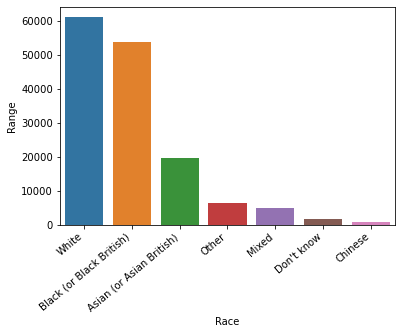

<Figure size 5760x2880 with 0 Axes>

In [251]:
import seaborn as sns
ax = sns.countplot(x = dataset['SubjectEthnicity'])
plt.figure(figsize=(80, 40))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('Race') 
ax.set_ylabel('Range')
plt.tight_layout()
plt.show()

### Age Analysis
To further explore the dataset, I created a graph that depicts the different age groups with the highest crime rates.

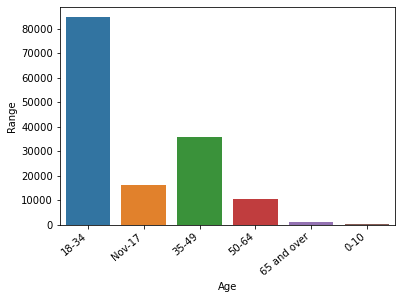

<Figure size 5760x2880 with 0 Axes>

In [252]:
ax = sns.countplot(x = dataset['SubjectAge'])
plt.figure(figsize=(80, 40))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('Age') 
ax.set_ylabel('Range')
plt.tight_layout()
plt.show()

### Gender Analysis
To investigate the gender most connected with crimes. When testing and minimising racism, this is another attribute that serves as the favoured and unfavoured groups.

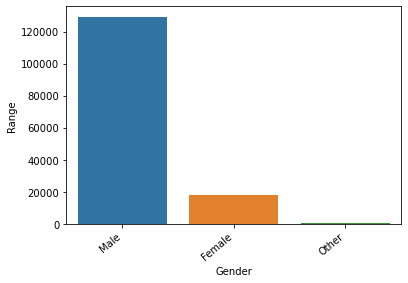

<Figure size 5760x2880 with 0 Axes>

In [253]:
import seaborn as sns
ax = sns.countplot(x = dataset['SubjectGender'])
plt.figure(figsize=(80, 40))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('Gender') 
ax.set_ylabel('Range')
plt.tight_layout()
plt.show()

### Dropping NaNs
Finally, after dropping the columns with the largest percentage of missing values, this should remove all NaNs from the datatest. This is to confirm that I do not train the model with NaNs.

In [254]:
#Drop all Nan (Not a number)
print("Number of rows before dropping NaNs: %d" % len(dataset))
dataset = dataset.dropna()
print("Number of rows after dropping NaNs: %d" % len(dataset))

Number of rows before dropping NaNs: 147895
Number of rows after dropping NaNs: 147895


### Copy Clean File to CSV
This is to confirm that the dataset is clean and to sure all preprocessing I have done has been revised.

In [255]:
dataset.to_csv('crime-data-cleaned.csv', header=True, index=False)

### Convert the Date and time to numbers
It is important that I translate the date and time to numbers before standardising the data, or else an error message will be displayed.

In [256]:
from datetime import datetime
dataset['IncidentDate'] = pd.to_numeric(pd.to_datetime(dataset['IncidentDate']))
dataset['IncidentTime'] = pd.to_numeric(pd.to_datetime(dataset['IncidentTime']))

### Convert categorical variables to numbers
I used the label encoder from the Python library to translate the majority of the yes and no responses into binary values such as 0's and 1's.

In [257]:
from sklearn.preprocessing import LabelEncoder

dataset[["Incident Location: Street/Highway"]] = dataset[["Incident Location: Street/Highway"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Public Transport"]] = dataset[["Incident Location: Public Transport"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Public Transportject"]] =dataset[["Incident Location: Public Transport"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Retail Premises"]] = dataset[["Incident Location: Retail Premises"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Open ground (e.g. park, car park, field)"]] = dataset[["Incident Location: Open ground (e.g. park, car park, field)"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Licensed Premises"]] = dataset[["Incident Location: Licensed Premises"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Sports or Event Stadia"]] = dataset[["Incident Location: Sports or Event Stadia"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Hospital/A&E (non-mental-health setting)"]] = dataset[["Incident Location: Hospital/A&E (non-mental-health setting)"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Mental Health Setting"]] = dataset[["Incident Location: Mental Health Setting"]].apply(LabelEncoder().fit_transform)
dataset[["PhysicalDisability"]] = dataset[["PhysicalDisability"]].apply(LabelEncoder().fit_transform)
dataset[["MentalDisability"]] = dataset[["MentalDisability"]].apply(LabelEncoder().fit_transform)
dataset[["Firearms Aimed"]] = dataset[["Firearms Aimed"]].apply(LabelEncoder().fit_transform)
dataset[["Firearms Fired"]] = dataset[["Firearms Fired"]].apply(LabelEncoder().fit_transform)
dataset[["StaffInjured"]] = dataset[["StaffInjured"]].apply(LabelEncoder().fit_transform)
dataset[["SubjectEthnicity"]] = dataset[["SubjectEthnicity"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Made off/escaped"]] = dataset[["Outcome: Made off/escaped"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Arrested"]] = dataset[["Outcome: Arrested"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Hospitalised"]] = dataset[["Outcome: Hospitalised"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Detained - Mental Health Act"]] = dataset[["MentalDisability"]].apply(LabelEncoder().fit_transform)
dataset[["MentalDisability"]] = dataset[["Outcome: Detained - Mental Health Act"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Fatality"]] = dataset[["Outcome: Fatality"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Other"]] = dataset[["Outcome: Other"]].apply(LabelEncoder().fit_transform)
dataset[["MentalDisability"]] = dataset[["MentalDisability"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Police vehicle with prisoner handling cage"]] = dataset[["Incident Location: Police vehicle with prisoner handling cage"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Police vehicle without prisoner handling cage"]] = dataset[["Incident Location: Police vehicle without prisoner handling cage"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Dwelling"]] = dataset[["Incident Location: Dwelling"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Police station (excluding custody block)"]] = dataset[["Incident Location: Police station (excluding custody block)"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Custody Block"]] = dataset[["Incident Location: Custody Block"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Ambulance"]] = dataset[["Incident Location: Ambulance"]].apply(LabelEncoder().fit_transform)
dataset[["Incident Location: Other"]] = dataset[["Incident Location: Other"]].apply(LabelEncoder().fit_transform)
dataset[["AssaultedBySubject"]] = dataset[["AssaultedBySubject"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Possesion of a weapon"]] = dataset[["Impact Factor: Possesion of a weapon"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Alcohol"]] = dataset[["Impact Factor: Alcohol"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Drugs"]] = dataset[["Impact Factor: Drugs"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Mental Health"]] = dataset[["Impact Factor: Mental Health"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Prior Knowledge"]] = dataset[["Impact Factor: Prior Knowledge"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Size/Gender/Build"]] = dataset[["Impact Factor: Size/Gender/Build"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Acute Behavioural Disorder"]] = dataset[["Impact Factor: Acute Behavioural Disorder"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Crowd"]] = dataset[["Impact Factor: Crowd"]].apply(LabelEncoder().fit_transform)
dataset[["Impact Factor: Other"]] = dataset[["Impact Factor: Other"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Protect self"]] = dataset[["Reason for Force: Protect self"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Protect Public"]] = dataset[["Reason for Force: Protect Public"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Protect Subject"]] = dataset[["Reason for Force: Protect Subject"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Protect Other Officers"]] = dataset[["Reason for Force: Protect Other Officers"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Prevent Offence"]] = dataset[["Reason for Force: Prevent Offence"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Secure Evidence"]] = dataset[["Reason for Force: Secure Evidence"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Effect Search"]] = dataset[["Reason for Force: Effect Search"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Effect Arrest"]] = dataset[["Reason for Force: Effect Arrest"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Method of Entry"]] = dataset[["Reason for Force: Method of Entry"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Remove Handcuffs"]] = dataset[["Reason for Force: Remove Handcuffs"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Prevent Harm"]] = dataset[["Reason for Force: Prevent Harm"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Prevent Escape"]] = dataset[["Reason for Force: Prevent Escape"]].apply(LabelEncoder().fit_transform)
dataset[["Reason for Force: Other"]] = dataset[["Reason for Force: Other"]].apply(LabelEncoder().fit_transform)
dataset[["SingleCrewed"]] = dataset[["SingleCrewed"]].apply(LabelEncoder().fit_transform)
dataset[["TrainedCED"]] = dataset[["TrainedCED"]].apply(LabelEncoder().fit_transform)
dataset[["Effective 1"]] = dataset[["Effective 1"]].apply(LabelEncoder().fit_transform)
dataset[["PhysicalDisability"]] = dataset[["PhysicalDisability"]].apply(LabelEncoder().fit_transform)
dataset[["MentalDisability"]] = dataset[["MentalDisability"]].apply(LabelEncoder().fit_transform)
dataset[["StaffInjured"]] = dataset[["StaffInjured"]].apply(LabelEncoder().fit_transform)
dataset[["SubjectInjured"]] = dataset[["SubjectInjured"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Made off/escaped"]] = dataset[["Outcome: Made off/escaped"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Arrested"]] = dataset[["Outcome: Arrested"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Hospitalised"]] = dataset[["Outcome: Hospitalised"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Detained - Mental Health Act"]] = dataset[["Outcome: Detained - Mental Health Act"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Fatality"]] = dataset[["Outcome: Fatality"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Other"]] = dataset[["Outcome: Other"]].apply(LabelEncoder().fit_transform)
dataset[["Outcome: Made off/escaped"]] = dataset[["Outcome: Made off/escaped"]].apply(LabelEncoder().fit_transform)
dataset.head(20)

,IncidentDate,IncidentTime,Incident Location: Street/Highway,Incident Location: Public Transport,Incident Location: Retail Premises,"Incident Location: Open ground (e.g. park, car park, field)",Incident Location: Licensed Premises,Incident Location: Sports or Event Stadia,Incident Location: Hospital/A&E (non-mental-health setting),Incident Location: Mental Health Setting,...,MentalDisability,StaffInjured,SubjectInjured,Outcome: Made off/escaped,Outcome: Arrested,Outcome: Hospitalised,Outcome: Detained - Mental Health Act,Outcome: Fatality,Outcome: Other,Incident Location: Public Transportject
0,1578096000000000000,1619655120000000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1578096000000000000,1619659800000000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1578096000000000000,1619667000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1578096000000000000,1619670300000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1578096000000000000,1619669520000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1578096000000000000,1619659800000000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1578096000000000000,1619667000000000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,1578096000000000000,1619674500000000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
8,1578096000000000000,1619665200000000000,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
9,1578096000000000000,1619655900000000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### One-Hot encoding on categorical variables
I have used the get_dummies which can also be referred to One-Hot encoding. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature.

In [258]:
dataset = pd.get_dummies(dataset, columns=["Borough","PrimaryConduct","MainDuty","Tactic 1","SubjectAge","SubjectGender"])
dataset

,IncidentDate,IncidentTime,Incident Location: Street/Highway,Incident Location: Public Transport,Incident Location: Retail Premises,"Incident Location: Open ground (e.g. park, car park, field)",Incident Location: Licensed Premises,Incident Location: Sports or Event Stadia,Incident Location: Hospital/A&E (non-mental-health setting),Incident Location: Mental Health Setting,...,"Tactic 1_Unarmed skills (including pressure points, strikes, restraints and take-downs)",SubjectAge_0-10,SubjectAge_18-34,SubjectAge_35-49,SubjectAge_50-64,SubjectAge_65 and over,SubjectAge_Nov-17,SubjectGender_Female,SubjectGender_Male,SubjectGender_Other
0,1578096000000000000,1619655120000000000,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1578096000000000000,1619659800000000000,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,1578096000000000000,1619667000000000000,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1578096000000000000,1619670300000000000,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
4,1578096000000000000,1619669520000000000,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147890,1612051200000000000,1619719200000000000,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
147891,1612051200000000000,1619709600000000000,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
147892,1612051200000000000,1619733600000000000,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
147893,1612051200000000000,1619725680000000000,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### After converting all the categorical variable to numbers then i will fit X,Y sampling.
I used X to get all of the attributes in the dataset except the target variable, which is why I dropped y. y is the target variable, which means the 'Impact Factor  possession of weapon'  by the suspect.

In [259]:
X = dataset.drop('Impact Factor: Possesion of a weapon', axis=1)

y = dataset['Impact Factor: Possesion of a weapon']


### Normalizing over the standard deviation
Let's now normalise the dataset. So why do I need to be standardized in the first place? Normalization is a statistical technique that enables mathematical-based algorithms to interpret features of varying magnitudes and distributions in an equal manner. To normalise our dataset, I used StandardScaler() from sci-kit read.

In [260]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-1.96834151, -2.02890535,  0.85335203, ..., -0.37359549,
         0.38014749, -0.06165113],
       [-1.96834151, -1.83695074,  0.85335203, ...,  2.67669185,
        -2.63055794, -0.06165113],
       [-1.96834151, -1.54163595, -1.17184933, ...,  2.67669185,
        -2.63055794, -0.06165113],
       ...,
       [ 1.45690717,  1.19002582, -1.17184933, ..., -0.37359549,
         0.38014749, -0.06165113],
       [ 1.45690717,  0.86517956,  0.85335203, ..., -0.37359549,
         0.38014749, -0.06165113],
       [ 1.45690717,  0.79627277, -1.17184933, ..., -0.37359549,
         0.38014749, -0.06165113]])

### Over-sampling and under-sampling on unbalanced data
To handle the uneven distribution of target data, the strategy of under sampling was used. The approach taken to under sampling was that of an edited nearest neighbour technique. The imblearn library provides an EditedNarestNeighbours library that was considered appropriate for use with the crime data. This technique involves identifying data points that belong to a Tomek link and removing this link, in the process removing points from the dataset.

In [261]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

0.7.0


0.7.0
Class=0, n=72001 (68.234%)
Class=1, n=33519 (31.766%)


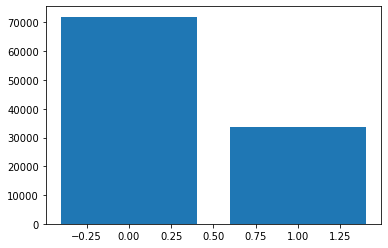

In [262]:
print(imblearn.__version__)

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import EditedNearestNeighbours 

oversample = SMOTE()
enn = EditedNearestNeighbours()
# label encode the target variable

y = LabelEncoder().fit_transform(y)

X, y = enn.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100

    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
#plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### Train Test and Split
In order to evaluate the performance of the model, I will have to split my dataset into two subsets. The first subset is used to fit the model and is referred to as the training dataset. While the second one which is referred to as the test data is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. 0.3 implies that i am using 30% for the test data and using 70% for the training data

In [263]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Decision Tree Classifier
This is one of the Machine Learning algortihm used to evaluate the several courses of action to take when solving a classification problem. Decision Tree helps train a model that can be used to predict the class or value of the target variable by learning simple decision rules inferred from prior data(training data)  

In [264]:
import warnings
from sklearn.tree import DecisionTreeClassifier
biased_dt = DecisionTreeClassifier()
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

#### Fit both the x and y training data and use this to predict the test outcome.

In [265]:
biased_dt.fit(x_train, y_train)
y_pred=biased_dt.predict(x_test)

### Score Accuracy (x_test and y_test) 
The test data are usually used to predict the score accuracy when building a model. The score determines how good the model is and the same applies to the other three classification algorithms I will be using in this experiment. 

In [266]:
biased_dt.score(x_test,y_test)

0.7977950467525904

### Cross-Validation score
It is time to check the accuracy of the model and how well the model performs on an unseen data, as well evaluating the scores.

In [267]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
score = cross_val_score(biased_dt, x_train, y_train, cv=5) 
print('Cross-validation score: ',score)
print('Cross-validation mean score: ',score.mean())

Cross-validation score:  [0.78677317 0.78893928 0.78623164 0.7850132  0.78608178]
Cross-validation mean score:  0.7866078126551997


### Summarize Classification 
This different accuracy scores describe how the good the model is and they all have their own purpose.  The score closer to 0 defines a poor model accuracy while the score closer to 1 implies how good the model will be. 

In [268]:
def summarize_classification(y_test,y_pred,avg_method='weighted'):
    acc = accuracy_score(y_test, y_pred,normalize=True)
    num_acc = accuracy_score(y_test, y_pred,normalize=False)
    f1= f1_score(y_test, y_pred, average=avg_method)
    prec = precision_score(y_test, y_pred, average=avg_method)
    recall = recall_score(y_test, y_pred, average=avg_method)
    
    print("Length of testing data: ", len(y_test))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("f1_score : " , f1)
    print("precision_score : " , prec)
    print("recall_score : ", recall)

### Model Result
The Summary describes the model performance as mentioned earlier. It shows the length of testing data, accuracy count, accuracy score, f1 score, precision score and recall.

In [269]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
summarize_classification(y_test, y_pred)

Length of testing data:  31656
accuracy_count :  25255
accuracy_score :  0.7977950467525904
f1_score :  0.7982804871025391
precision_score :  0.7988200166420094
recall_score :  0.7977950467525904


### Logistic Regression Classifier
Logisitic regression classifier is another classification algortihm used when the value of the target variable is categorical in nature. It is used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1. Which is why based on the features the model was trained it will yield a binary value as the Impact Factor for the criminal.  

In [270]:
from sklearn.linear_model import LogisticRegression
biased_lr=LogisticRegression(C=0.01, solver='liblinear')
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

#### Fit both the x and y training data and use this to predict the test outcome. Repeat the same thing I did earlier for the decision tree.

In [271]:
biased_lr.fit(x_train,y_train)
y_pred=biased_lr.predict(x_test)

### Score Accuracy (x_test and y_test)
The test data are usually used to predict the score accuracy when building a model. The score determines how good the model will be.

In [272]:
biased_lr.score(x_test,y_test)

0.8328910791003286

### Cross-Validation score
It is time to check the accuracy of the model and how well the model performs on an unseen data and as well evaluating the scores.

In [273]:
score = cross_val_score(biased_lr, x_train, y_train, cv=5) 
print('Cross-validation score: ',score)
print('Cross-validation mean score: ',score.mean())

Cross-validation score:  [0.83381845 0.83476613 0.82962161 0.82244635 0.82906851]
Cross-validation mean score:  0.8299442099574627


### Summarize Classification
This different accuracy scores describe how the good the model is and they all have their own purpose. The score closer to 0 defines a poor model accuracy while the score closer to 1 implies how good the model will be.

In [274]:
def summarize_classification(y_test,y_pred,avg_method='weighted'):
    acc = accuracy_score(y_test, y_pred,normalize=True)
    num_acc = accuracy_score(y_test, y_pred,normalize=False)
    f1= f1_score(y_test, y_pred, average=avg_method)
    prec = precision_score(y_test, y_pred, average=avg_method)
    recall = recall_score(y_test, y_pred, average=avg_method)
    
    print("Length of testing data: ", len(y_test))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("f1_score : " , f1)
    print("precision_score : " , prec)
    print("recall_score : ", recall)

### Model Result
The Summary describes the model performance as mentioned earlier. It shows the length of testing data, accuracy count, accuracy score, f1 score, precision score and recall.

In [275]:
summarize_classification(y_test, y_pred)

Length of testing data:  31656
accuracy_count :  26366
accuracy_score :  0.8328910791003286
f1_score :  0.827954452828242
precision_score :  0.8292282477272428
recall_score :  0.8328910791003286


### Random Forest Classifier
This is the final classification algorithm used to build and compare the prediction performance of the machine learning model.  It creates many classification trees and a bootstrap sample technique is used to train each tree from the set of training data.

In [276]:
from sklearn.ensemble import RandomForestClassifier
biased_rfc=RandomForestClassifier()
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

#### Fit both the x and y training data and use this to predict the test outcome. Repeat the same thing I did earlier in Logistic Regression.

In [277]:
biased_rfc.fit(x_train, y_train)
y_pred=biased_rfc.predict(x_test)

### Score Accuracy (x_test and y_test)
The test data are usually used to predict the score accuracy when building a model. The score describes the accuracy performance of the model.

In [278]:
biased_rfc.score(x_test,y_test)

0.8550037907505686

### Cross-Validation score
It is time to check the accuracy of the model and how well the model performs on an unseen data and as well evaluating the scores.

In [279]:
score = cross_val_score(biased_rfc, x_train, y_train, cv=5) 
print('Cross-validation score: ',score)
print('Cross-validation mean score: ',score.mean())

Cross-validation score:  [0.85446423 0.85412577 0.84552901 0.84288905 0.84402924]
Cross-validation mean score:  0.8482074599505113


### Summarize Classification
This different accuracy scores describe how the good the model is and they all have their own purpose. The score closer to 0 defines a poor model accuracy while the score closer to 1 implies how good the model will be.

In [280]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
def summarize_classification(y_test,y_pred,avg_method='weighted'):
    acc = accuracy_score(y_test, y_pred,normalize=True)
    num_acc = accuracy_score(y_test, y_pred,normalize=False)
    f1= f1_score(y_test, y_pred, average=avg_method)
    prec = precision_score(y_test, y_pred, average=avg_method)
    recall = recall_score(y_test, y_pred, average=avg_method)
    
    print("Length of testing data: ", len(y_test))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("f1_score : " , f1)
    print("precision_score : " , prec)
    print("recall_score : ", recall)

### Model Result
The Summary describes the model performance as mentioned earlier. It shows the length of testing data, accuracy count, accuracy score, f1 score, precision score and recall.

In [281]:
summarize_classification(y_test, y_pred)

Length of testing data:  31656
accuracy_count :  27066
accuracy_score :  0.8550037907505686
f1_score :  0.8495716840251478
precision_score :  0.8539806038489943
recall_score :  0.8550037907505686


In [282]:
#Accuracy performance
pred_results = pd.DataFrame({'y_test': pd.Series(y_test),
                             'y_pred': pd.Series(y_pred)})

pred_results.sample(10)

,y_test,y_pred
26685,0,0
30635,0,0
31293,0,0
27332,1,1
4043,0,0
5830,1,0
20564,0,0
12863,1,1
31450,1,1
18121,0,0


### AI FAIRNESS 360 Metrics (Building a fair model)
Before applying any bias mitigation algorithm or even calculating fairness metrics, I will need to set up a BinaryLabelDataset object (which is one of the AIF360) to hold the data. Then I will specify race as a protected attribute, and black (label:1) as the underprivileged group.

In [ ]:
from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric 
train_pp_bld = BinaryLabelDataset(df=pd.concat((x_train, y_train),
                                               axis=1),
                                  label_names=['Impact Factor: Possesion of a weapon'],
                                  protected_attribute_names=['SubjectEthnicity'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'SubjectEthnicity': 1}]
unprivileged_groups = [{'SubjectEthnicity': 0}]

### Explainer Metric
AIF includes a metrics and an explainer class for running relevant metrics on various types of datasets. In this section, I will add a method that will explain everything relevant to the problem with an expressive call of explain().

In [117]:
from typing import List, Union, Dict
class MetricAdditions:
    def explain(self,
                disp: bool=True) -> Union[None, str]:
        """Explain everything available for the given metric."""

        # Find intersecting methods/attributes between MetricTextExplainer and provided metric.
        inter = set(dir(self)).intersection(set(dir(self.metric)))

        # Ignore private and dunder methods
        metric_methods = [getattr(self, c) for c in inter if c.startswith('_') < 1]

        # Call methods, join to new lines
        s = "\n".join([f() for f in metric_methods if callable(f)])

        if disp:
            print(s)
        else:
            return s
        
        
class MetricTextExplainer_(MetricTextExplainer, MetricAdditions):
    """Combine explainer and .explain."""
    pass

### aif360.datasets.BinaryLabelDataset
Base class for all structured datasets with binary labels. The parameters for BinaryLabelDatasetMetric consist of the favorable label which is considered positive and the unfavorable label which value is considered negative. In this case I have used unprivileged and privileged groups.

In [168]:
# Create the metric object
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld, unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

# Create the explainer object
explainer = MetricTextExplainer_(metric_train_bld)
# Explain relevant metrics
explainer.explain()

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.0729177014565093
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7421831096923983
Consistency (Zemel, et al. 2013): [0.73902208]
Number of negative-outcome instances: 80114.0
Number of instances: 103526.0
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.0729177014565093
Number of positive-outcome instances: 23412.0


### Reweighing Algorithm
Reweighting is procedure of finding such weights for original distribution, that make distribution of one or several variables identical in original distribution and target distribution. Reweighing has no effect on the training data; rather, it learns new weights for each training row that result in a mean difference in outcomes between the listed classes of 0.

Specifically, in this case:
- Examples of **Blacks** who were not in possession of weapon will be **downweighted**.
- Examples of **Blacks** who were in possession of weapon will be **upweighted**.
- Examples of **Whites** who were in possession of weapon will be **downweighted**.
- Examples of **Whites** who were not in possession of weapon will be **upweighted**.
- Examples of **Asians** who were not in possession of weapon will be **downweighted**.
- Examples of **Asians** who were in possession of weapon will be **upweighted**.
- Examples of **Others** who were in possession of weapon will be **downweighted**.
- Examples of **Others** who were not in possession of weapon will be **upweighted**.
- Examples of **Mixed** who were not in possession of weapon will be **downweighted**.
- Examples of **Mixed** who were in possession of weapon will be **upweighted**.
- Examples of **Don't Know** who were in possession of weapon will be **downweighted**.
- Examples of **Don't Know** who were not in possession of weapon will be **upweighted**.
- Examples of **Chinese** who were not in possession of weapon will be **downweighted**.
- Examples of **Chinese** who were in possession of weapon will be **upweighted**.

In [169]:
from aif360.explainers import MetricTextExplainer 
from aif360.algorithms.preprocessing import Reweighing

In [170]:
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
train_pp_bld_f = rw.fit_transform(train_pp_bld)

#### The new weights are saved in instance_weights, as seen below:

In [171]:
pd.DataFrame({'SubjectEthnicity': x_train.SubjectEthnicity,
              'Impact Factor: Possesion of a weapon': y_train,
              'Original_weight': np.ones(shape=(x_train.shape[0],)),
              'new_weight': train_pp_bld_f.instance_weights}).sample(10)

,SubjectEthnicity,Impact Factor: Possesion of a weapon,Original_weight,new_weight
115546,6,0,1.0,1.000000
23477,1,0,1.0,1.079035
5718,6,1,1.0,1.000000
68029,6,1,1.0,1.000000
86406,6,1,1.0,1.000000
101055,0,0,1.0,0.979450
95939,1,1,1.0,0.799590
78779,6,0,1.0,1.000000
76822,4,0,1.0,1.000000
1143,0,0,1.0,0.979450


### MetricTextExplainer
When the fairness metrics are recalculated for the current row weights, there can be little disparity in the average results between the privileged and unprivileged classes.

In [172]:
# Create the metric object
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld_f,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

# Create the explainer object
explainer = MetricTextExplainer_(metric_train_bld)
# Explain relevant metrics
explainer.explain()

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -1.3877787807814457e-16
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999993
Consistency (Zemel, et al. 2013): [0.73902208]
Number of negative-outcome instances: 82031.02412920426
Number of instances: 103526.00000000003
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -1.3877787807814457e-16
Number of positive-outcome instances: 21494.975870795744


### Build Unbiased Models (Logistic Regression, Decision Tree and Random Forest)
The new weights, along with the unaltered results, are fed into the classifier for training. I don not need to add something to the test set when making forecasts because the training data is unaltered.

In [173]:
unbiased_lr = LogisticRegression()
unbiased_lr.fit(x_train, y_train, sample_weight=train_pp_bld_f.instance_weights)
unbiased_lr.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0])

In [174]:
unbiased_dt = DecisionTreeClassifier()
unbiased_dt.fit(x_train, y_train, sample_weight=train_pp_bld_f.instance_weights)
unbiased_dt.predict(x_test)

array([1, 0, 0, ..., 0, 1, 0])

In [175]:
unbiased_rfc = RandomForestClassifier(n_estimators=100, max_depth=4)
unbiased_rfc.fit(x_train, y_train, sample_weight=train_pp_bld_f.instance_weights)
unbiased_rfc.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0])

### Score Performance After Mitigating Bias
- Logistic regression score did not change compared to when the model was unfair.
- Random forest score has changed as compared to when the model was bias.
- Decision tree had a few changes in score but not much.

In [176]:
print(f"Logistic regression validation accuracy: {unbiased_lr.score(x_test, y_test)}")
print(f"Random forest validation accuracy: {unbiased_rfc.score(x_test, y_test)}")
print(f"Decision Tree validation accuracy: {unbiased_dt.score(x_test, y_test)}")

Logistic regression validation accuracy: 0.7722058193783948
Random forest validation accuracy: 0.7835200252428497
Decision Tree validation accuracy: 0.7832044896211319


### AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) & AUROC (Area Under the Receiver Operating Characteristics)
The model performance measurement is an important task. So, for a classification problem, I can rely on an AUC - ROC Curve. I will use the AUC, ROC curve to verify or visualize the output of the multi-class classification query. It is one of the most critical assessment criteria for assessing the success of any classification model. It is sometimes abbreviated as AUROC.

Accuracy:


,LogReg,RFC,DT
Unfair,0.772206,0.83493,0.785684
Fair,0.772206,0.78352,0.783204


AUC:


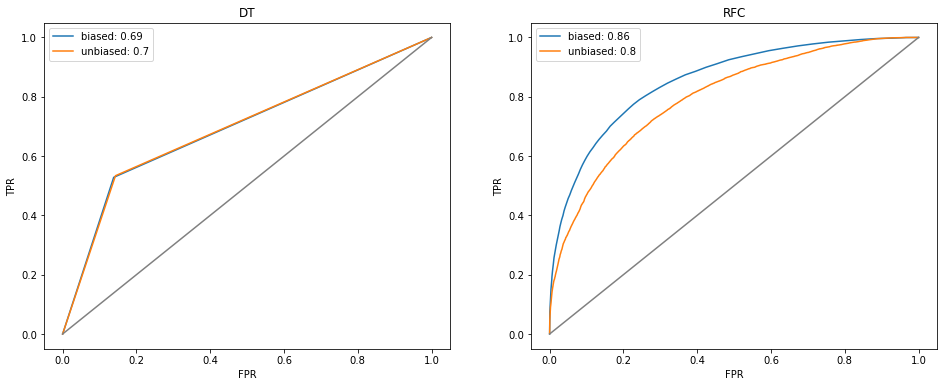

In [177]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
import seaborn as sns
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
    
    ax.legend(leg)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [biased_lr.score(x_test, y_test), 
                                 unbiased_lr.score(x_test, y_test)],
                      'RFC': [biased_rfc.score(x_test, y_test),
                              unbiased_rfc.score(x_test, y_test)], 
                      'DT':[biased_dt.score(x_test, y_test),
                              unbiased_dt.score(x_test, y_test)]},
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
plot_auc(y_test, 
         {'biased': biased_dt.predict_proba(x_test)[:, 1],
          'unbiased': unbiased_dt.predict_proba(x_test)[:, 1]},
         title='DT',
         ax=ax[0]) 
plot_auc(y_test, 
         {'biased': biased_rfc.predict_proba(x_test)[:, 1],
          'unbiased': unbiased_rfc.predict_proba(x_test)[:, 1]},
         title='RFC',
         ax=ax[1]) 
plt.show()

Accuracy:


,LogReg
Unfair,0.772206
Fair,0.772206


AUC:


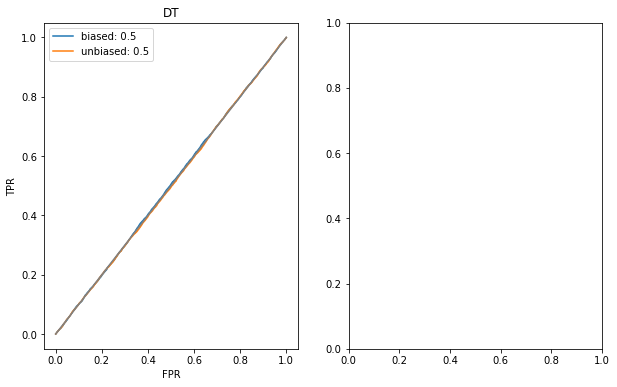

In [178]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
import seaborn as sns
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
    
    ax.legend(leg)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [biased_lr.score(x_test, y_test), 
                                 unbiased_lr.score(x_test, y_test)]},
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
plot_auc(y_test, 
         {'biased': biased_lr.predict_proba(x_test)[:, 1],
          'unbiased': unbiased_lr.predict_proba(x_test)[:, 1]},
         title='DT',
         ax=ax[0]) 
plt.show()

In [179]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

### Bias Mitigation Metrics
The classification threshold applied to the estimated probabilities determines the model's accuracy. Similarly, fairness differs with this threshold; members of the same group can have similar prediction odds, assuming the group is statistical, and may thus be divided by the chosen threshold.

The code below will compute the model's balanced accuracy at various threshold levels. As a test of justice, disparate effect and average chances disparity are measured.

- **Balanced accuracy** - is a metric that can be used to assess the output of a binary classifier. It is particularly helpful where the classes are skewed, i.e. one of the two classes exists much more often than the other.
- **Average odds difference** - A value of 0 implies both groups have equal benefit. 
- **Disparate impact** - A value 1 simply implies that both have equal benefit while a value less than 1 implies higher benefit for the privileged group, and a value greater than 1 implies higher benefit for the underprivileged group, (score closer to 0.5 is better in this case)

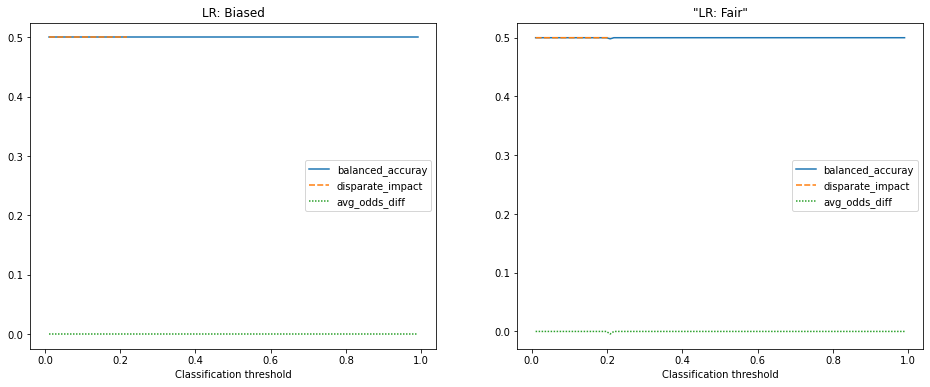

In [180]:
import warnings
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true),
                                               axis=1),
                             label_names=['Impact Factor: Possesion of a weapon'],
                             protected_attribute_names=['SubjectEthnicity'],
                             favorable_label=1,
                             unfavorable_label=0)

    privileged_groups = [{'SubjectEthnicity': 1}]
    unprivileged_groups = [{'SubjectEthnicity': 0}]
    
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1]

    balanced_accuracy = []
    disp_impact = []
    avg_odd_diff = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100)
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
        avg_odd_diff.append(valid_metric.average_odds_difference())
        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'balanced_accuray': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'avg_odds_diff': avg_odd_diff},
                          index=thresh)
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

# Plot for LR
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biased_lr, x_test, y_test),
                ax=ax[0],
                title="LR: Biased")
    
    plot_metrics(calc_metrics(unbiased_lr, x_test, y_test),
                ax=ax[1],
                title='"LR: Fair"')


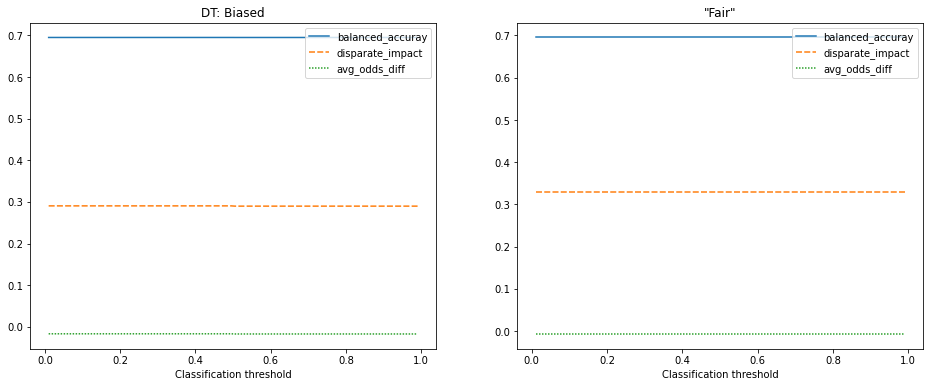

In [181]:
# Plot for DT
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biased_dt, x_test, y_test),
                ax=ax[0],
                title="DT: Biased")
    
    plot_metrics(calc_metrics(unbiased_dt, x_test, y_test),
                ax=ax[1],
                title='"Fair"')

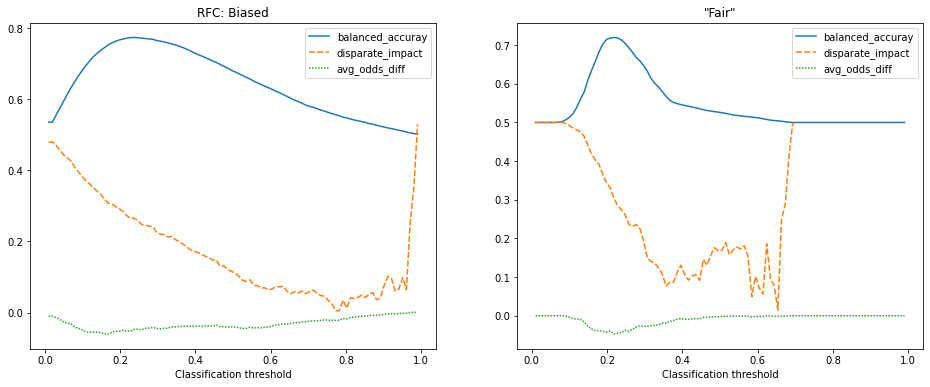

In [182]:
# Plot for RFC
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biased_rfc, x_test, y_test),
                ax=ax[0],
                title="RFC: Biased")
    
    plot_metrics(calc_metrics(unbiased_rfc, x_test, y_test),
                ax=ax[1],
                title='"Fair"')

### Prejudice Remover (Fairness Metric)
This is an in-processing technique that is used to help detect bias and mitigate bias in machine learning models. It adds a discrimination-aware regularization term to the learning objective. The parameters are sensitive_attr which consist of the protected attribute and eta which measures the fairness penalty. I have used fit on the training data and predict that will be passed to the explainer metric.   

In [183]:
model = PrejudiceRemover(sensitive_attr="SubjectEthnicity", eta=25.0)
train_pp_bld_m = model.fit(train_pp_bld)

In [184]:
train_pp_bld_m = model.predict(train_pp_bld)

### aif360.datasets.BinaryLabelDataset
Base class for all structured datasets with binary labels. The parameters for BinaryLabelDatasetMetric consist of the favorable label which is considered positive and the unfavorable label which value is considered negative. In this case I have used unprivileged and privileged groups just like I did for the reweighing metric.

In [185]:
# Create the metric object
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld_m,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

# Create the explainer object
explainer = MetricTextExplainer_(metric_train_bld)
# Explain relevant metrics
explainer.explain()

invalid value encountered in double_scalars


Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.0
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): nan
Consistency (Zemel, et al. 2013): [1.]
Number of negative-outcome instances: 103526.0
Number of instances: 103526.0
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): 0.0
Number of positive-outcome instances: 0.0


### Conclusion
In this experiment, I have demonstrated how to build a machine learning model capable of forecasting crime and aiding in pre-dictive policing. Furthermore, I was able to test the efficiency of  various  classification  algorithms  on  the  proposed  dataset, which  worked  admirably.  After  building  a  model,  I  prepared my model to be examined for bias using the binarylabeldatasetmetric  and  minimize  bias  using  reweighing,  a  preprocessing technique. I have measured how well the classifiers improved fairness  using  disparate  effects,  average  odd,  and  balanced precision. 

Lastly, there   is   a   very   high   possibility   of   police   bias   where intelligent  policing  leverages  sensitive  personal  information such as race and gender in the development of AI capabilities. Artificial intelligence will always pick up inherent bias in data, which  means  that  an  effective  way  to  prevent  bias  is  to  pay close  attention  to  training  datasets  and  get  rid  of  data  points that could contribute to bias. You will also realize that the model has a disparate impact score of 0.74 at the initial point when we attempted to check the model for bias before undertaking any bias mitigation, implying that the metropolitan police dataset is close to being fair, i.e both groups are been favored equally.

In [186]:
#dataset.to_csv('crime-data-cleaned.csv', header=True, index=False)


#train_data, validation_data, test_data = np.split(dataset.sample(frac=1), [int(.6*len(dataset)), int(.8*len(dataset))])


#train_data.to_csv('train.csv', header=False, index=False)
#validation_data.to_csv('validation.csv', header=False, index=False)
#test_data.to_csv('test.csv', header=False, index=False)